In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats
import math
import statsmodels.api as sm
import pylab
%matplotlib inline
from datetime import datetime

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample = pd.read_csv('sample_submission.csv')
dfr = pd.read_csv('fastest_routes_train_part_1.csv', usecols=['id','total_distance','total_travel_time','number_of_steps'])
dfr1 = pd.read_csv('fastest_routes_test.csv', usecols=['id','total_distance','total_travel_time','number_of_steps'])
df_route = pd.concat((dfr,dfr1))

# Clean Up the Data

In [9]:
df_train=df_train.merge(df_route,how='left',on='id')

In [11]:
df_train['total_distance'].fillna(df_train['total_distance'].mean(),inplace=True)
df_train['total_travel_time'].fillna(df_train['total_travel_time'].mean(),inplace=True)
df_train['number_of_steps'].fillna(df_train['number_of_steps'].mean(),inplace=True)
None

In [12]:
#remove trips with passengers >6 and outside 3std of the mean
df_train = df_train[df_train['passenger_count']<=6]
m = np.mean(df_train['trip_duration'])
s = np.std(df_train['trip_duration'])
df_train = df_train[df_train['trip_duration'] <= m + 3*s]
df_train = df_train[df_train['trip_duration'] >= m - 3*s]

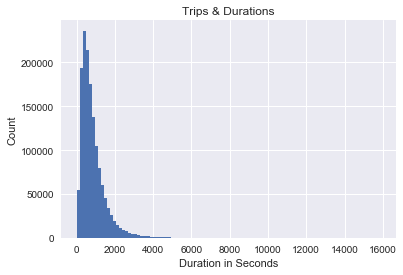

In [13]:
df_train.trip_duration.hist(bins=100)
plt.title('Trips & Durations')
plt.ylabel('Count')
plt.xlabel('Duration in Seconds')

(0, 10)

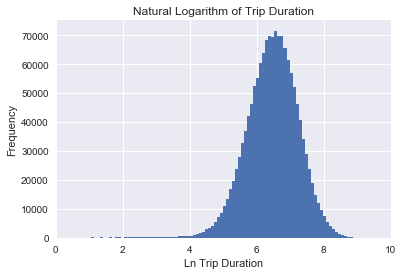

In [14]:
df_train['log_trip_duration'] = np.log(df_train['trip_duration'].values+1)
df_train['log_trip_duration'].plot.hist(bins=100)
plt.title('Natural Logarithm of Trip Duration')
plt.xlabel('Ln Trip Duration')
plt.xlim(0,10)

In [185]:
df_train['trip_duration'].max()/3600

4.416666666666667

In [178]:
np.log(834)

6.7262334023587469

In [15]:
df_train['trip_duration'].describe()

count    1.456566e+06
mean     8.371205e+02
std      6.613654e+02
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.073000e+03
max      1.590000e+04
Name: trip_duration, dtype: float64

In [16]:
#conversions to datetime and check the conversion worked well
df_train['pickup_datetime'] = pd.to_datetime(df_train.pickup_datetime)
df_test['pickup_datetime'] = pd.to_datetime(df_test.pickup_datetime)
df_train.loc[:, 'pickup_date'] = df_train['pickup_datetime'].dt.date
df_test.loc[:, 'pickup_date'] = df_test['pickup_datetime'].dt.date
df_train['dropoff_datetime'] = pd.to_datetime(df_train.dropoff_datetime)
df_train['store_and_fwd_flag'] = 1 * (df_train.store_and_fwd_flag.values == 'Y')
df_test['store_and_fwd_flag'] = 1 * (df_test.store_and_fwd_flag.values == 'Y')
df_train['check_trip_duration'] = (df_train['dropoff_datetime'] - df_train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = df_train[np.abs(df_train['check_trip_duration'].values  - df_train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

Trip_duration and datetimes are ok.


In [17]:
#add datetime versions of the original time stamps
df_train.loc[:, 'pickup_weekday'] = df_train['pickup_datetime'].dt.weekday
df_train.loc[:, 'pickup_hour_weekofyear'] = df_train['pickup_datetime'].dt.weekofyear
df_train.loc[:, 'pickup_hour'] = df_train['pickup_datetime'].dt.hour
df_train.loc[:, 'pickup_minute'] = df_train['pickup_datetime'].dt.minute
df_train.loc[:, 'pickup_dt'] = (df_train['pickup_datetime'] - df_train['pickup_datetime'].min()).dt.total_seconds()
df_train.loc[:, 'pickup_week_hour'] = df_train['pickup_weekday'] * 24 + df_train['pickup_hour']
df_train['Month'] = df_train['pickup_datetime'].dt.month
df_test['Month'] = df_test['pickup_datetime'].dt.month

# Start Exploring

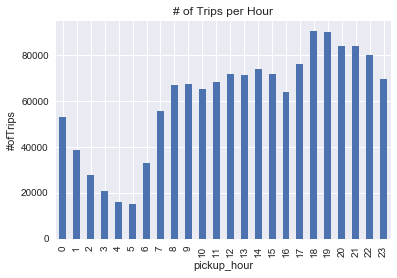

In [18]:
df_train.groupby(['pickup_hour']).size().plot.bar()
plt.title('# of Trips per Hour')
plt.ylabel('#ofTrips')
#number of trips each hour, peaking around dinner time

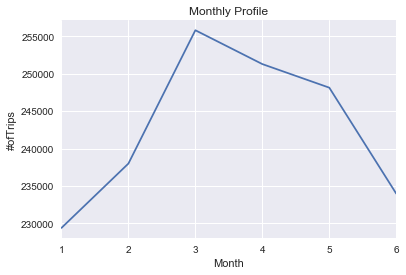

In [19]:
df_train.groupby(['Month']).size().plot.line()
plt.ylabel('#ofTrips')
plt.title('Monthly Profile')
#strange that data is only 6 months of the year???

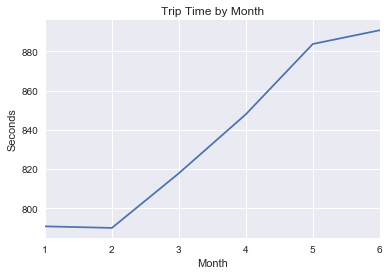

In [191]:
df_train.groupby(['Month'])['trip_duration'].mean().plot.line()
plt.title('Trip Time by Month')
plt.ylabel('Seconds')
#do the trip times increase as a result of summer?

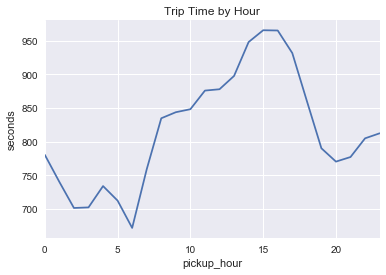

In [192]:
df_train.groupby(['pickup_hour'])['trip_duration'].mean().plot.line()
plt.ylabel('seconds')
plt.title('Trip Time by Hour')
#do the trip times increase as a result of rush hour? not really it seems there is a big peak at 3pm
#lulls in ridership in early morning and around 8pm

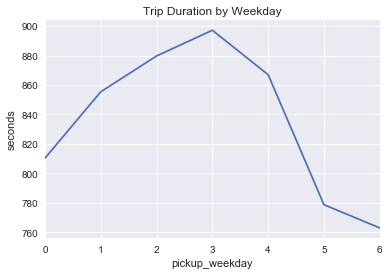

In [193]:
df_train.groupby(['pickup_weekday'])['trip_duration'].mean().plot.line()
plt.ylabel('seconds')
plt.title('Trip Duration by Weekday')
#peak traffic on wednesdays

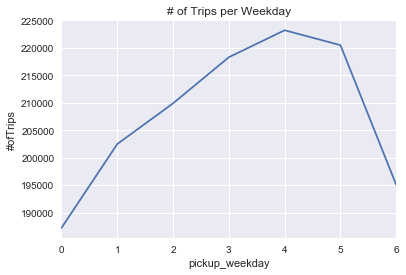

In [194]:
df_train.groupby(['pickup_weekday']).size().plot.line()
plt.title('# of Trips per Weekday')
plt.ylabel('#ofTrips')

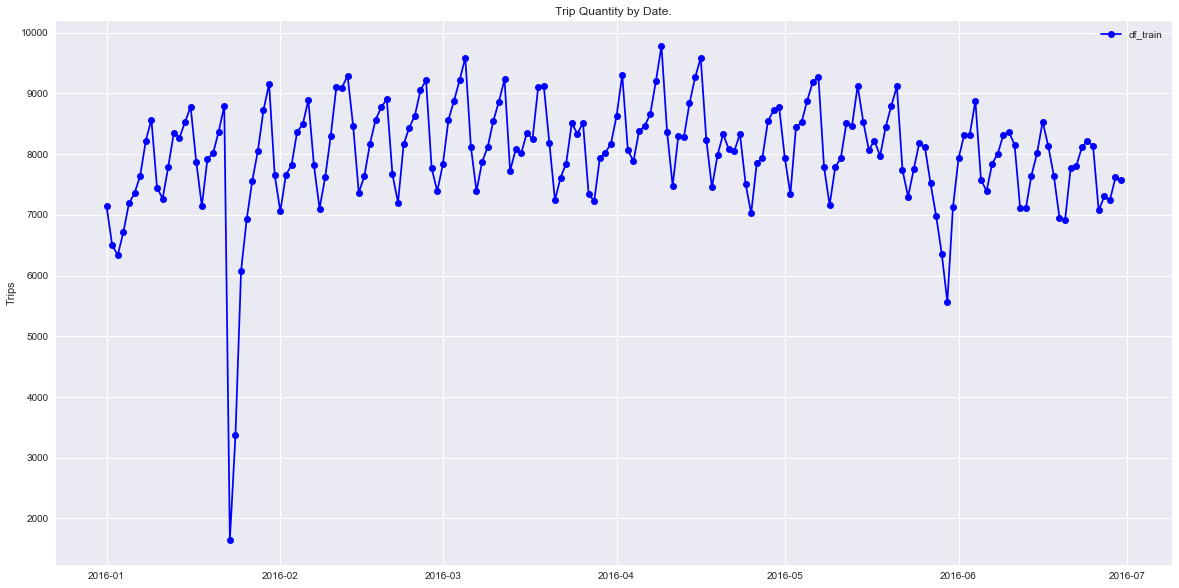

In [20]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(df_train.groupby('pickup_date').count()[['id']], 'bo-', label='df_train')
plt.title('Trip Quantity by Date.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

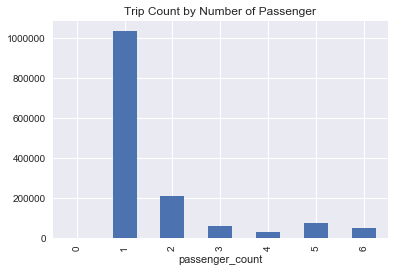

In [213]:
df_train.groupby(['passenger_count']).size().plot.bar()
plt.title('Trip Count by Number of Passenger')

In [21]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,log_trip_duration,pickup_date,check_trip_duration,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,Month
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,6.122493,2016-03-14,455.0,0,11,17,24,6369878.0,17,3
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,6.498282,2016-06-12,663.0,6,23,0,43,14085798.0,144,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,7.661527,2016-01-19,2124.0,1,3,11,35,1596907.0,35,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,...,6.063785,2016-04-06,429.0,2,14,19,32,8364734.0,67,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,...,6.077642,2016-03-26,435.0,5,12,13,30,7392638.0,133,3


In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456566 entries, 0 to 1458643
Data columns (total 24 columns):
id                        1456566 non-null object
vendor_id                 1456566 non-null int64
pickup_datetime           1456566 non-null datetime64[ns]
dropoff_datetime          1456566 non-null datetime64[ns]
passenger_count           1456566 non-null int64
pickup_longitude          1456566 non-null float64
pickup_latitude           1456566 non-null float64
dropoff_longitude         1456566 non-null float64
dropoff_latitude          1456566 non-null float64
store_and_fwd_flag        1456566 non-null int64
trip_duration             1456566 non-null int64
total_distance            1456566 non-null float64
total_travel_time         1456566 non-null float64
number_of_steps           1456566 non-null float64
log_trip_duration         1456566 non-null float64
pickup_date               1456566 non-null object
check_trip_duration       1456566 non-null float64
pickup_weekday  

In [268]:
df_train['passenger_count'].describe()

count    699070.000000
mean          1.660601
std           1.314689
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           6.000000
Name: passenger_count, dtype: float64

Explore the following using hypothesis testing or correlations:
 1. Is there a statistical difference between the taxi vendors trip durations?
 - trip duration vs passenger count
 - trip duration vs time of year (seasonal, i.e. summer/winter)
 - impact of rush hour on trip duration
 - demonstrate the trip durations to airports is related to the pickup distance from the airport
 - trip duration vs total distance (need to import the OCRM data)
 
 
 Cleaning Data:
 - remove the super long trips: set limit to 3 standard deviations from mean
 - remove the trips with >5 passengers : removed all trips with passengers >6
 - remove trips that have zero distance and greater than 5 minutes  <<<don't know how to do yet>>>

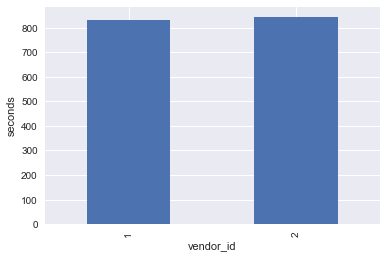

In [198]:
df_train.groupby(['vendor_id'])['trip_duration'].mean().plot.bar()
plt.ylabel('seconds')

In [199]:
vendor1_df = df_train[df_train['vendor_id']==1]
vendor2_df = df_train[df_train['vendor_id']==2]

trip = df_train.as_matrix(columns=['trip_duration'])

vendor1_trip = vendor1_df.as_matrix(columns=['trip_duration'])
vendor2_trip = vendor2_df.as_matrix(columns=['trip_duration'])

mu_vendor1 = np.mean(vendor1_trip)
sig_vendor1 = np.std(vendor1_trip)

mu_vendor2 = np.mean(vendor2_trip)
sig_vendor2 = np.std(vendor2_trip)

mu_trip = np.mean(trip)
sig_trip = np.std(trip)

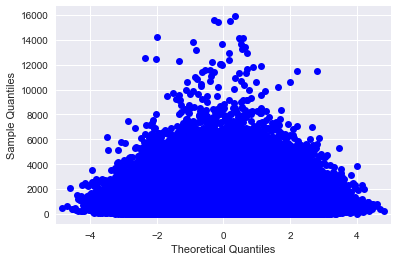

In [200]:
sm.qqplot(trip)
pylab.show()

In [201]:
stats.mstats.normaltest(trip)

NormaltestResult(statistic=masked_array(data = [810422.2242228067],
             mask = [False],
       fill_value = 1e+20)
, pvalue=array([ 0.]))

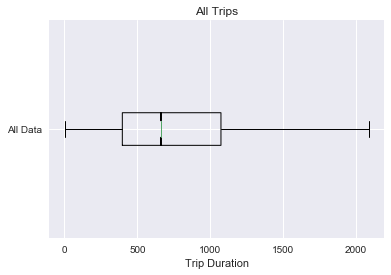

In [202]:
plt.figure()
plt.boxplot([trip],1 ,'rs',0, labels=['All Data'],showfliers=False)
plt.xlabel('Trip Duration')
plt.title('All Trips')
None

In [203]:
df_train.groupby(['vendor_id'])['id'].count()
#huge sample, probably will use z-stat assuming it is representative of the population standard deviation

vendor_id
1    678333
2    778233
Name: id, dtype: int64

In [204]:
def get_z(sample1, sample2):
    z = (np.mean(sample1) - np.mean(sample2)) / math.sqrt(np.std(sample1)**2/len(sample1)+np.std(sample2)**2/len(sample2))
    return z


def get_t(sample, null_hypo):
    t = (np.mean(sample) - null_hypo) / (np.std(sample) / math.sqrt(len(sample)))
    return t

In [205]:
z = get_z(vendor1_trip, vendor2_trip)
print('Z statastic:', z)
#makes it very unlikely that the means are statistically equal, null hypothesis will be rejected

Z statastic: -10.7069562755


Ho: mu1 - mu2 = deltao
Ha: mu1 - mu2 < deltao

This is to say that for Ha, the mean trip duration of vendor 1 is less than mean trip duration of vendor 2. This inequality indicates a lower tailed test where we reject the null hypothesis if z<= -zalpha

For an alpha value of 0.95 the Zcritical value is 1.65 meaning that in order to reject the null hypothesis our calculated statistic has to be z<= -1.65.

In this case our z statistic is -10.7 which is less than -1.65 and so we must reject the null hypothesis that the mean trip durations are equal and accept that vendor 1 has a lower mean trip duration than vendor 2.

The P-value is also 0 meaning Ho should be rejected for any reasonable significance level.

It is also fair to say that although the means are different, they are not different by much and this will likely not be a significant factor in determining trip duration.

# Series of Box Plots

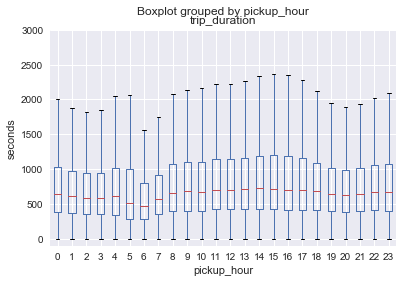

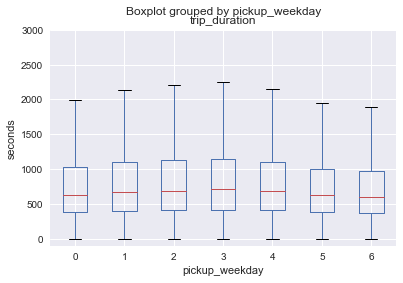

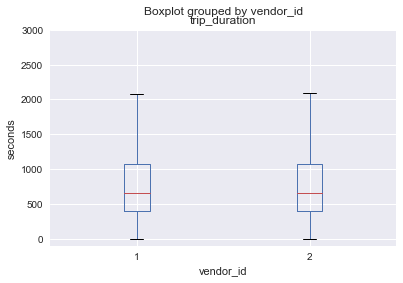

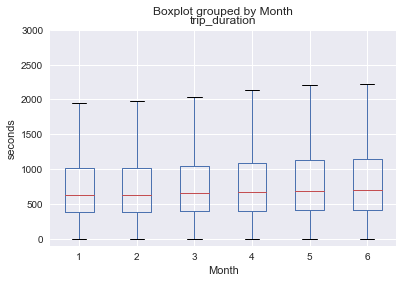

In [206]:
#how do i use matplotlib axis objects?
ax=df_train.boxplot(column='trip_duration',by='pickup_hour')
ax.set_ylim(-100,3000)
ax.set_ylabel ('seconds')

ax1=df_train.boxplot(column='trip_duration',by='pickup_weekday')
ax1.set_ylim(-100,3000)
ax1.set_ylabel ('seconds')

ax2=df_train.boxplot(column='trip_duration',by='vendor_id')
ax2.set_ylim(-100,3000)
ax2.set_ylabel ('seconds')

ax3=df_train.boxplot(column='trip_duration',by='Month')
ax3.set_ylim(-100,3000)
ax3.set_ylabel ('seconds')

# Test for Correlation Between Trip Duration & Passenger Count

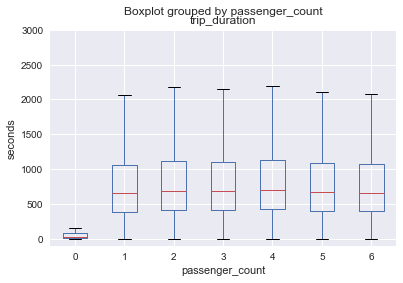

In [207]:
ax4=df_train.boxplot(column='trip_duration',by='passenger_count')
ax4.set_ylim(-100,3000)
ax4.set_ylabel('seconds')

# Lets add in the direct distance formulas & calculate average speed

In [23]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [24]:
df_train.loc[:, 'distance_haversine'] = haversine_array(df_train['pickup_latitude'].values, df_train['pickup_longitude'].values, df_train['dropoff_latitude'].values, df_train['dropoff_longitude'].values)
    
df_train.loc[:, 'direction'] = bearing_array(df_train['pickup_latitude'].values, df_train['pickup_longitude'].values, df_train['dropoff_latitude'].values, df_train['dropoff_longitude'].values)

df_train.loc[:, 'speed'] = 1000*df_train['distance_haversine']/df_train['trip_duration']

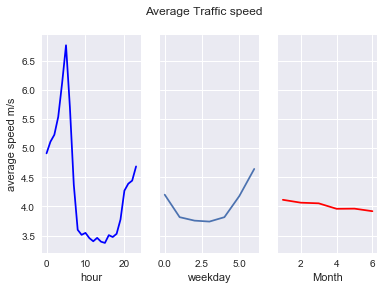

In [210]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(df_train.groupby('pickup_hour')['speed'].mean(),'b-')
ax[1].plot(df_train.groupby('pickup_weekday')['speed'].mean())
ax[2].plot(df_train.groupby('Month')['speed'].mean(), 'r-')
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('Month')
ax[0].set_ylabel('average speed m/s')
fig.suptitle('Average Traffic speed')
plt.show()

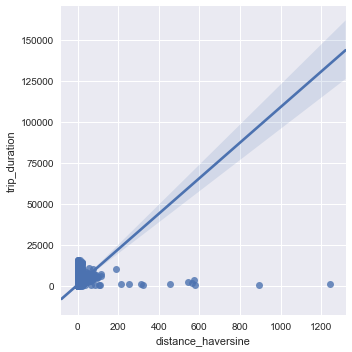

In [211]:
lm = sns.lmplot(x='distance_haversine',y='trip_duration',data=df_train)

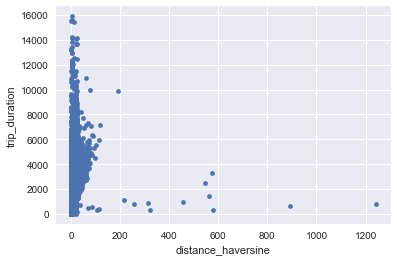

In [213]:
df_train.plot.scatter(x='distance_haversine',y='trip_duration')
#plt.ylim(0,2000)
#plt.xlim(0,25)

# Lets incorporate the Neighbourhoods via K-Means Clustering

In [25]:
coords = np.vstack((df_train[['pickup_latitude', 'pickup_longitude']].values,
                    df_train[['dropoff_latitude', 'dropoff_longitude']].values,
                    df_test[['pickup_latitude', 'pickup_longitude']].values,
                    df_test[['dropoff_latitude', 'dropoff_longitude']].values))

In [26]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [216]:
t0 = datetime.now()
df_train.loc[:, 'pickup_cluster'] = kmeans.predict(df_train[['pickup_latitude', 'pickup_longitude']])
df_train.loc[:, 'dropoff_cluster'] = kmeans.predict(df_train[['dropoff_latitude', 'dropoff_longitude']])
df_test.loc[:, 'pickup_cluster'] = kmeans.predict(df_test[['pickup_latitude', 'pickup_longitude']])
df_test.loc[:, 'dropoff_cluster'] = kmeans.predict(df_test[['dropoff_latitude', 'dropoff_longitude']])
t1 = datetime.now()
print('Custering Time: %i seconds' % (t1 - t0).seconds)

Custering Time: 5 seconds


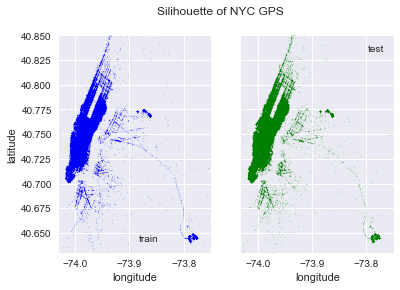

In [11]:
N = 100000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(df_train['pickup_longitude'].values[:N], df_train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(df_test['pickup_longitude'].values[:N], df_test['pickup_latitude'].values[:N],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Silihouette of NYC GPS')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

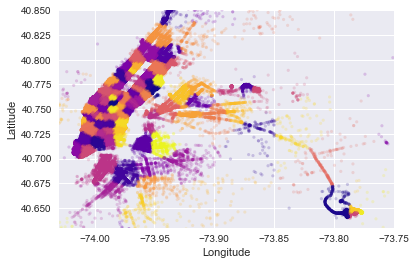

In [219]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(df_train.pickup_longitude.values[:500000], df_train.pickup_latitude.values[:500000], s=10, lw=0,
           c=df_train.pickup_cluster[:500000].values, cmap='plasma', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

**chose not generate the silhouette reports as there are around 100 neighbourhoods in NYC according to Wikipedia**
https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City

**instead, performed elbow method and conveniently it selected k=5 as best...there are 5 boroughs in NYC!!!**

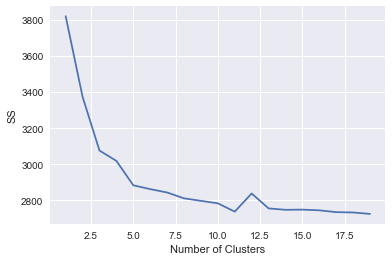

In [239]:
x =list(range(1,20))
y =[]
for k in range(1,20):
    kmeans = MiniBatchKMeans(n_clusters = k)
    kmeans.fit(coords[sample_ind])
    y.append(kmeans.inertia_)
plt.plot(x,y)
plt.ylabel("SS")
plt.xlabel("Number of Clusters")

# Repeat KMeans with 5 clusters & incorporate for models

In [27]:
kmeans5 = MiniBatchKMeans(n_clusters=5, batch_size=10000).fit(coords[sample_ind])

In [28]:
t0 = datetime.now()
df_train.loc[:, 'pickup_cluster'] = kmeans5.predict(df_train[['pickup_latitude', 'pickup_longitude']])
df_train.loc[:, 'dropoff_cluster'] = kmeans5.predict(df_train[['dropoff_latitude', 'dropoff_longitude']])
df_test.loc[:, 'pickup_cluster'] = kmeans5.predict(df_test[['pickup_latitude', 'pickup_longitude']])
df_test.loc[:, 'dropoff_cluster'] = kmeans5.predict(df_test[['dropoff_latitude', 'dropoff_longitude']])
t1 = datetime.now()
print('Custering Time: %i seconds' % (t1 - t0).seconds)

Custering Time: 1 seconds


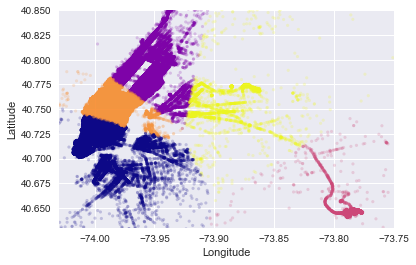

In [14]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(df_train.pickup_longitude.values[:500000], df_train.pickup_latitude.values[:500000], s=10, lw=0,
           c=df_train.pickup_cluster[:500000].values, cmap='plasma', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [275]:
df_train.pickup_cluster.describe()

count    699070.000000
mean          2.025142
std           1.273086
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: pickup_cluster, dtype: float64

In [ ]:
cluster_pickup_train = pd.get_dummies(df_train['pickup_cluster'], prefix='p', prefix_sep='_')
#cluster_pickup_test = pd.get_dummies(df_test['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(df_train['dropoff_cluster'], prefix='d', prefix_sep='_')
#cluster_dropoff_test = pd.get_dummies(df_test['dropoff_cluster'], prefix='d', prefix_sep='_')

# Training the Model

In [60]:
X = df_train[['Month','pickup_hour','pickup_weekday','direction','total_distance','number_of_steps','distance_haversine','vendor_id','passenger_count','pickup_cluster','dropoff_cluster']]
y = df_train['trip_duration']


In [61]:
from sklearn.model_selection import train_test_split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [63]:
from sklearn.linear_model import LinearRegression

In [64]:
lm = LinearRegression()

In [65]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [66]:
# The coefficients
print('Coefficients: \n', lm.coef_)

Coefficients: 
 [  1.87016105e+01   3.74300376e+00  -1.31699874e+01   1.85063968e-02
   8.31412805e-02   1.75681333e+01   9.94991191e+01   3.05266928e+00
   3.74970426e+00   7.55077606e+00  -7.85027203e+00]


## Predicting Test Data
Now that we have fit our model, let's evaluate its performance by predicting off the test values!

** Use lm.predict() to predict off the X_test set of the data.**

In [67]:
predictions = lm.predict( X_test)

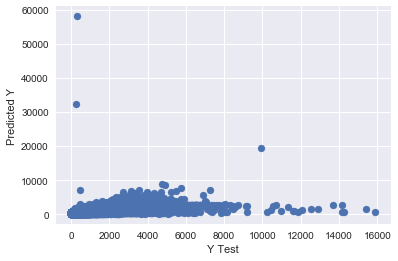

In [68]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

## Evaluating the Model

Let's evaluate our model performance by calculating the residual sum of squares and the explained variance score (R^2).

** Calculate the Mean Absolute Error, Mean Squared Error, and the Root Mean Squared Error. Refer to the lecture or to Wikipedia for the formulas**

In [69]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 286.360463312
MSE: 190623.305356
RMSE: 436.604289209


In [70]:
print('R Squared: ', metrics.r2_score(y_test,predictions))

R Squared:  0.56585041456


## Residuals

Let's quickly explore the residuals to make sure everything was okay with our data. 

**Plot a histogram of the residuals and make sure it looks normally distributed.**

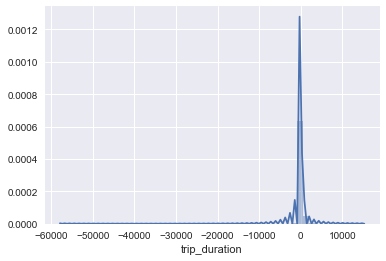

In [71]:
sns.distplot((y_test-predictions),bins=50)


## Conclusion



In [72]:
coeffecients = pd.DataFrame(lm.coef_,X.columns)
coeffecients.columns = ['Coefficient']
coeffecients.sort_values(by='Coefficient',ascending=False)

,Coefficient
distance_haversine,99.499119
Month,18.701611
number_of_steps,17.568133
pickup_cluster,7.550776
passenger_count,3.749704
pickup_hour,3.743004
vendor_id,3.052669
total_distance,0.083141
direction,0.018506
dropoff_cluster,-7.850272


# Begin a Decision Tree Model

In [73]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456566 entries, 0 to 1458643
Data columns (total 29 columns):
id                        1456566 non-null object
vendor_id                 1456566 non-null int64
pickup_datetime           1456566 non-null datetime64[ns]
dropoff_datetime          1456566 non-null datetime64[ns]
passenger_count           1456566 non-null int64
pickup_longitude          1456566 non-null float64
pickup_latitude           1456566 non-null float64
dropoff_longitude         1456566 non-null float64
dropoff_latitude          1456566 non-null float64
store_and_fwd_flag        1456566 non-null int64
trip_duration             1456566 non-null int64
total_distance            1456566 non-null float64
total_travel_time         1456566 non-null float64
number_of_steps           1456566 non-null float64
log_trip_duration         1456566 non-null float64
pickup_date               1456566 non-null object
check_trip_duration       1456566 non-null float64
pickup_weekday  

**Create Dummy Variables for all Categorical items We want to include in model**

In [112]:
vendor_train = pd.get_dummies(df_train['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(df_train['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(df_train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
cluster_pickup_train = pd.get_dummies(df_train['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(df_train['dropoff_cluster'], prefix='d', prefix_sep='_')
month_train = pd.get_dummies(df_train['Month'], prefix='m', prefix_sep='_')
hour_train = pd.get_dummies(df_train['pickup_hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(df_train['pickup_weekday'], prefix='dow', prefix_sep='_')


** Opt to use the actual values vs dummies**

In [123]:
forest_train = df_train[['log_trip_duration','distance_haversine','direction','total_distance','number_of_steps','passenger_count','Month','pickup_hour','pickup_weekday','pickup_cluster','dropoff_cluster']]


**Opt to use the dummy variables**

In [114]:
#forest_train = pd.concat([forest_train,passenger_count_train,month_train,hour_train,dow_train,cluster_pickup_train,cluster_dropoff_train],axis=1)

In [124]:
forest_train.shape

(1456566, 11)

In [125]:
#sample the original data for ease of calculation tests
forest_train_sample = forest_train.sample(frac=0.2)

In [126]:
forest_train_sample.shape

(291313, 11)

**Set up the dependent and independent matrices**

In [127]:
Xf = forest_train.drop('log_trip_duration',axis=1)
yf = forest_train['log_trip_duration']
X_train, X_test, y_train, y_test = train_test_split(Xf, yf, test_size=0.2, random_state=100)

In [46]:
#import the DT regressor
from sklearn.tree import DecisionTreeRegressor

In [128]:
#limit the depth to n-1 branches, equivalent to the degrees of freedom in the dataframe
dtree = DecisionTreeRegressor(max_depth=10)

In [129]:
dtree.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [130]:
predictions = dtree.predict(X_test)

In [131]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.292537529406
MSE: 0.165760672918
RMSE: 0.407137167203


In [132]:
print('R Squared: ', metrics.r2_score(y_test,predictions))

R Squared:  0.723295856928


**We Improved the Model over Linear Regression!**

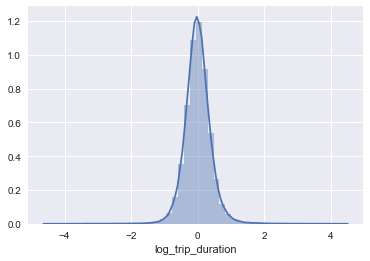

In [133]:
sns.distplot((y_test-predictions),bins=50)

In [134]:
coeffecientsDT = pd.DataFrame(dtree.feature_importances_,Xf.columns)
coeffecientsDT.columns = ['FeatureImportance']
coeffecientsDT.sort_values(by='FeatureImportance',ascending=False)

,FeatureImportance
distance_haversine,0.864009
pickup_hour,0.049913
total_distance,0.021487
direction,0.020277
dropoff_cluster,0.016606
pickup_weekday,0.013931
number_of_steps,0.006502
pickup_cluster,0.004430
passenger_count,0.001866
Month,0.000978


# Now try a RandomForestRegressor

In [84]:
from sklearn.ensemble import RandomForestRegressor

In [101]:
rfc = RandomForestRegressor(max_depth=10)

In [135]:
rfc.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [136]:
predictionsRF = rfc.predict(X_test)

In [137]:
print('MAE:', metrics.mean_absolute_error(y_test, predictionsRF))
print('MSE:', metrics.mean_squared_error(y_test, predictionsRF))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictionsRF)))

MAE: 0.286227155273
MSE: 0.159956660167
RMSE: 0.39994582154


In [138]:
print('R Squared: ', metrics.r2_score(y_test,predictionsRF))

R Squared:  0.732984490223


# only slight improvement over the DT Regressor

In [139]:
coefficientsRF = pd.DataFrame(rfc.feature_importances_,Xf.columns)
coefficientsRF.columns = ['FeatureImportance']
coefficientsRF.sort_values(by='FeatureImportance',ascending=False)


,FeatureImportance
distance_haversine,0.862328
pickup_hour,0.050013
total_distance,0.022114
direction,0.020941
dropoff_cluster,0.016465
pickup_weekday,0.014654
number_of_steps,0.006623
pickup_cluster,0.004059
passenger_count,0.001793
Month,0.001011


** The table above shows us the importance of each feature, as was evident in the Linear Model, distance of the trip is much larger magnitude than remaining variables **

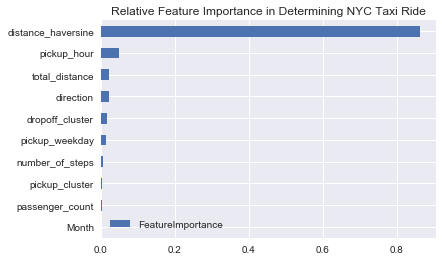

In [141]:
coefficientsRF.sort_values(by='FeatureImportance',ascending=True).plot.barh()
plt.title('Relative Feature Importance in Determining NYC Taxi Ride')